<a href="https://colab.research.google.com/github/thdefn/AIproj2022/blob/master/trs_learning__Fine_Tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


### VGG19 전이학습 Bottleneck FT 사용한 버전
모델, 히스토리 저장 링크
https://drive.google.com/drive/folders/1pTTZI_bfVOVXptYJ-GdtdU5HMW5geO0p?usp=sharing



In [1]:
import numpy as np
import pandas as pd
import math

from tensorflow import keras

from tensorflow.keras import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Conv2D, MaxPooling2D, Dense, Flatten, GlobalAveragePooling2D
from tensorflow.keras.layers import Dropout, BatchNormalization 
from tensorflow.keras.utils import to_categorical
import pickle

In [2]:
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.vgg16 import VGG16
from keras.applications.vgg19 import preprocess_input
from tensorflow.keras.callbacks import ModelCheckpoint

import matplotlib.pyplot as plt

import seaborn as sns
import os
import glob
import plotly.graph_objects as go
import cv2
from PIL import Image
from PIL import ImageFile
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import RMSprop, SGD
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau,ModelCheckpoint 
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import warnings
warnings.filterwarnings("ignore")
ImageFile.LOAD_TRUNCATED_IMAGES = True

from tqdm import tqdm

In [ ]:
import os
from google.colab import drive
drive.mount('/content/gdrive')

In [ ]:
cd /content/gdrive/My Drive/data/.kaggle

In [5]:
X_valid = np.load('./X_valid_128.npy',allow_pickle=True)
y_valid = np.load('./y_valid_128.npy',allow_pickle=True)
X_train = np.load('./X_train_128.npy',allow_pickle=True)
y_train = np.load('./y_train_128.npy',allow_pickle=True)

X_train = X_train/255
X_valid = X_valid/255

le = LabelEncoder().fit(['Type 1', 'Type 2', 'Type 3'])
y_train = le.transform(y_train)
y_valid = le.transform(y_valid)

y_train_onehot = to_categorical(y_train, num_classes=3)
y_valid_onehot = to_categorical(y_valid, num_classes=3)

In [6]:
reduceLR = ReduceLROnPlateau(monitor='val_accuracy', patience=10, verbose= 1, mode='max', factor=  0.2, min_lr = 1e-5)

early = EarlyStopping(monitor='val_loss', patience=10)
#early_stopping = EarlyStopping(monitor='val_accuracy', patience = 20, verbose=1, mode='max', restore_best_weights= True)

checkpointer = ModelCheckpoint('best_bottleneck_model.hdf5',save_best_only = True,verbose = 1)

In [7]:
BATCH_SIZE = 16
TRAIN_STEPS = len(X_train)//BATCH_SIZE
VAL_STEPS = len(X_valid)//BATCH_SIZE
t = ImageDataGenerator(rotation_range=0.3, zoom_range=0.3)
valid_gen = t.flow(X_valid, y_valid_onehot, batch_size = BATCH_SIZE)
train_gen = t.flow(X_train, y_train_onehot, batch_size = BATCH_SIZE)
base_model = VGG19(include_top=False, weights='imagenet')
train_data = base_model.predict_generator(train_gen, int(math.ceil(len(X_train) / BATCH_SIZE)) )  
valid_data = base_model.predict_generator(valid_gen, int(math.ceil(len(X_valid) / BATCH_SIZE)) )  


In [8]:
model = Sequential([
    GlobalAveragePooling2D(input_shape=train_data.shape[1:]),
    Dense(3, activation='softmax')
])


model.compile(optimizer=RMSprop(lr=1e-4),
              loss='categorical_crossentropy', metrics=['accuracy'])  

bottleneck = model.fit(train_data, y_train_onehot, validation_data= (valid_data, y_valid_onehot), epochs= 100, verbose=1,  batch_size=BATCH_SIZE, callbacks= [checkpointer]) #피팅


Epoch 1/100
394/411 [===========================>..] - ETA: 0s - loss: 1.0545 - accuracy: 0.4794
Epoch 1: val_loss improved from inf to 1.00827, saving model to best_bottleneck_model.hdf5
411/411 [==============================] - 3s 6ms/step - loss: 1.0541 - accuracy: 0.4798 - val_loss: 1.0083 - val_accuracy: 0.5313
Epoch 2/100
407/411 [============================>.] - ETA: 0s - loss: 1.0089 - accuracy: 0.5283
Epoch 2: val_loss improved from 1.00827 to 1.00778, saving model to best_bottleneck_model.hdf5
411/411 [==============================] - 1s 4ms/step - loss: 1.0090 - accuracy: 0.5275 - val_loss: 1.0078 - val_accuracy: 0.5313
Epoch 3/100
411/411 [==============================] - ETA: 0s - loss: 1.0075 - accuracy: 0.5275
Epoch 3: val_loss improved from 1.00778 to 1.00743, saving model to best_bottleneck_model.hdf5
411/411 [==============================] - 1s 3ms/step - loss: 1.0075 - accuracy: 0.5275 - val_loss: 1.0074 - val_accuracy: 0.5301
Epoch 4/100
400/411 [==============

In [13]:
# 사전 교육된 기본 모델 가져오기
base_model = VGG19(include_top=False, weights='imagenet', input_shape=(128,128,3))

# 교육할 계층 설정 최상위 계층만 교육하기 위해 (False 가중치 고정)
for layer in base_model.layers:
    layer.trainable = False
    
trs = Sequential([
    base_model,
    Dropout(0.2),
    Flatten(),
    BatchNormalization(),
    Dense(1024,kernel_initializer='he_uniform'),
    BatchNormalization(),
    Activation('relu'),
    Dropout(0.2),
    Dense(1024,kernel_initializer='he_uniform'),
    BatchNormalization(),
    Activation('relu'),
    Dropout(0.2),
    Dense(1024,kernel_initializer='he_uniform'),
    BatchNormalization(),
    Activation('relu'),
    Dropout(0.2),
    Dense(3, activation='softmax')
])

trs.summary()

# t_gen.samples == size of train df
#verimggen = trs.fit(t_gen, steps_per_epoch = t_gen.samples//16, validation_data= v_nongen, epochs= 10, verbose=1)

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 4, 4, 512)         20024384  
                                                                 
 dropout (Dropout)           (None, 4, 4, 512)         0         
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 batch_normalization (BatchN  (None, 8192)             32768     
 ormalization)                                                   
                                                                 
 dense_3 (Dense)             (None, 1024)              8389632   
                                                                 
 batch_normalization_1 (Batc  (None, 1024)             4096      
 hNormalization)                                      

세이빙한 모델 가져오는 부분

In [14]:
#trs = keras.models.load_model('VGG19_verimggen.h5') #모델 가져오기
trs.compile(optimizer= SGD(lr=1e-4, momentum=0.9),
  loss='categorical_crossentropy', 
  metrics=['accuracy'])

In [16]:
es = EarlyStopping(monitor='val_loss', mode='min', patience=6,restore_best_weights=True, verbose=1)
verimggen = trs.fit(train_gen, validation_data= valid_gen, epochs= 60, verbose=1,  steps_per_epoch = TRAIN_STEPS, callbacks= [es]) #피팅
trs.save('VGG19_BT.h5')

Epoch 1/60
410/410 [==============================] - 37s 86ms/step - loss: 1.2033 - accuracy: 0.4360 - val_loss: 1.0142 - val_accuracy: 0.4948
Epoch 2/60
410/410 [==============================] - 33s 80ms/step - loss: 1.1260 - accuracy: 0.4703 - val_loss: 1.0131 - val_accuracy: 0.4991
Epoch 3/60
410/410 [==============================] - 33s 80ms/step - loss: 1.1004 - accuracy: 0.4769 - val_loss: 0.9878 - val_accuracy: 0.5247
Epoch 4/60
410/410 [==============================] - 33s 80ms/step - loss: 1.0668 - accuracy: 0.4912 - val_loss: 0.9719 - val_accuracy: 0.5180
Epoch 5/60
410/410 [==============================] - 33s 80ms/step - loss: 1.0601 - accuracy: 0.4892 - val_loss: 0.9641 - val_accuracy: 0.5429
Epoch 6/60
410/410 [==============================] - 33s 80ms/step - loss: 1.0445 - accuracy: 0.5004 - val_loss: 0.9661 - val_accuracy: 0.5222
Epoch 7/60
410/410 [==============================] - 33s 79ms/step - loss: 1.0345 - accuracy: 0.5043 - val_loss: 0.9517 - val_accuracy:

In [ ]:
with open('VGG19_bottle11.pkl', 'wb') as f:
	pickle.dump(verimggen.history, f, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
# history 담은 pickle file
trs = keras.models.load_model('VGG19_FT1.h5')
trs.compile(optimizer= SGD(lr=1e-4, momentum=0.9),
  loss='categorical_crossentropy', 
  metrics=['accuracy']) #옵티마이저 컴파일
verimggen = trs.fit(train_gen, validation_data= valid_gen, epochs= 60, verbose=1,  steps_per_epoch = TRAIN_STEPS, callbacks= [early]) #피팅
trs.save('VGG19_bottle11.h5')

Epoch 1/60
410/410 [==============================] - 36s 86ms/step - loss: 0.9216 - accuracy: 0.5501 - val_loss: 0.9252 - val_accuracy: 0.5575
Epoch 2/60
410/410 [==============================] - 37s 89ms/step - loss: 0.9233 - accuracy: 0.5523 - val_loss: 0.9230 - val_accuracy: 0.5612
Epoch 3/60
410/410 [==============================] - 35s 85ms/step - loss: 0.9166 - accuracy: 0.5471 - val_loss: 0.9236 - val_accuracy: 0.5600
Epoch 4/60
410/410 [==============================] - 35s 84ms/step - loss: 0.9209 - accuracy: 0.5549 - val_loss: 0.9225 - val_accuracy: 0.5557
Epoch 5/60
410/410 [==============================] - 34s 83ms/step - loss: 0.9186 - accuracy: 0.5547 - val_loss: 0.9175 - val_accuracy: 0.5612
Epoch 6/60
410/410 [==============================] - 35s 87ms/step - loss: 0.9182 - accuracy: 0.5529 - val_loss: 0.9204 - val_accuracy: 0.5587
Epoch 7/60
410/410 [==============================] - 38s 93ms/step - loss: 0.9174 - accuracy: 0.5507 - val_loss: 0.9242 - val_accuracy:

In [ ]:
with open('VGG19_FT1.pkl', 'rb') as f:
	df = pickle.load(f)

In [ ]:
 for i in range(len(verimggen.history['loss'])):
    df['loss'].append(verimggen.history['loss'][i])
    df['accuracy'].append(verimggen.history['accuracy'][i])
    df['val_loss'].append(verimggen.history['val_loss'][i])
    df['val_accuracy'].append(verimggen.history['val_accuracy'][i])

In [ ]:
with open('VGG19_FT2.pkl', 'wb') as f:
	pickle.dump(df, f, protocol=pickle.HIGHEST_PROTOCOL)

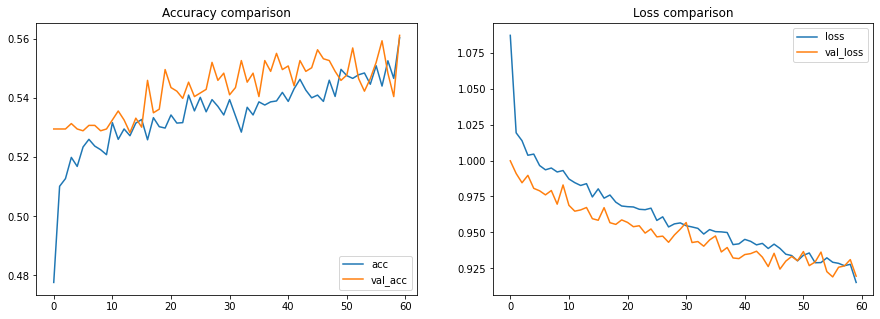

In [ ]:
import matplotlib.pyplot as plt


plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(df['accuracy'], label='acc')
plt.plot(df['val_accuracy'], label='val_acc')
plt.legend(loc='lower right')
plt.title('Accuracy comparison')

plt.subplot(1, 2, 2)
plt.plot(df['loss'], label='loss')
plt.plot(df['val_loss'], label='val_loss')
plt.legend(loc='upper right')
plt.title('Loss comparison')

plt.show()

모델 평가

In [ ]:
X_test = np.load('./X_test_128.npy',allow_pickle=True)/255
y_test = np.load('./y_test_128.npy',allow_pickle=True)
y_test = np.array(y_test).astype(np.float32)
trs.evaluate(X_test, y_test)

16/16 [==============================] - 107s 7s/step - loss: 0.9421 - accuracy: 0.5605


[0.9420881271362305, 0.560546875]

In [ ]:
import torch
y_test = torch.Tensor(y_test)
y_test = torch.argmax(y_test, dim=1)

In [ ]:
y_pred_enc = trs.predict(X_test)          # one-hot encoding된 label 예측값
y_pred = [np.argmax(i) for i in y_pred_enc] # label 예측값
matrix = confusion_matrix(y_test, y_pred)
item = {
      0: 'Type 1'
    , 1: 'Type 2'
    , 2: 'Type 3'
}
res = pd.DataFrame(matrix)
res.columns = item.values()
res.index = item.values()
        
res

16/16 [==============================] - 114s 7s/step


,Type 1,Type 2,Type 3
Type 1,0,72,15
Type 2,0,212,53
Type 3,0,85,75


### VGG19 전이학습 FineTuning 증강 버전
모델, 히스토리 저장 링크
https://drive.google.com/drive/folders/1pTTZI_bfVOVXptYJ-GdtdU5HMW5geO0p?usp=sharing

```
optimizer= SGD(lr=1e-4, momentum=0.9)
```



In [1]:
import numpy as np
import pandas as pd

from tensorflow import keras

from tensorflow.keras import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Conv2D, MaxPooling2D, Dense, Flatten, GlobalAveragePooling2D
from tensorflow.keras.layers import Dropout, BatchNormalization 
from tensorflow.keras.utils import to_categorical
import pickle

In [2]:
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.callbacks import ModelCheckpoint

import matplotlib.pyplot as plt

import seaborn as sns
import os
import glob
import plotly.graph_objects as go
import cv2
from PIL import Image
from PIL import ImageFile
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import RMSprop, SGD
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau,ModelCheckpoint 
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import warnings
warnings.filterwarnings("ignore")
ImageFile.LOAD_TRUNCATED_IMAGES = True

from tqdm import tqdm

In [4]:
import os
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [5]:
cd /content/gdrive/My Drive/data/.kaggle

/content/gdrive/My Drive/data/.kaggle


In [6]:
X_valid = np.load('./X_valid_128.npy',allow_pickle=True)
y_valid = np.load('./y_valid_128.npy',allow_pickle=True)
X_train = np.load('./X_train_128.npy',allow_pickle=True)
y_train = np.load('./y_train_128.npy',allow_pickle=True)

X_train = X_train/255
X_valid = X_valid/255

le = LabelEncoder().fit(['Type 1', 'Type 2', 'Type 3'])
y_train = le.transform(y_train)
y_valid = le.transform(y_valid)

y_train_onehot = to_categorical(y_train, num_classes=3)
y_valid_onehot = to_categorical(y_valid, num_classes=3)

In [7]:
reduceLR = ReduceLROnPlateau(monitor='val_accuracy', patience=10, verbose= 1, mode='max', factor=  0.2, min_lr = 1e-5)

early = EarlyStopping(monitor='val_loss', patience=10)
#early_stopping = EarlyStopping(monitor='val_accuracy', patience = 20, verbose=1, mode='max', restore_best_weights= True)

checkpoint_ag = ModelCheckpoint('v1_ag', monitor='val_accuracy', verbose=1,save_best_only=True, mode= 'max')

In [8]:
BATCH_SIZE = 16
TRAIN_STEPS = len(X_train)//BATCH_SIZE
VAL_STEPS = len(X_valid)//BATCH_SIZE
t = ImageDataGenerator(rotation_range=0.3, zoom_range=0.3)
valid_gen = t.flow(X_valid, y_valid_onehot, batch_size = BATCH_SIZE)
train_gen = t.flow(X_train, y_train_onehot, batch_size = BATCH_SIZE)

In [9]:
# 사전 교육된 기본 모델 가져오기
base_model = VGG19(include_top=False, weights='imagenet',input_shape=(128, 128, 3))

base_model.trainable = False

# 교육할 계층 설정 최상위 계층만 교육하기 위해 (False 가중치 고정)
for layer in base_model.layers:
    layer.trainable = False
    
# 기본 모델의 마지막 층
x = base_model.output

x = Flatten()(x)
h1 = Dense(512, activation='relu')(x)
drop1 = Dropout(rate=0.5)(h1)
h2 = Dense(512, activation='relu')(drop1)
drop2 = Dropout(rate=0.5)(h2)
output = Dense(3, activation='softmax')(drop2)

trs = Model(inputs=base_model.input, outputs=output)
trs.summary()

# t_gen.samples == size of train df
#verimggen = trs.fit(t_gen, steps_per_epoch = t_gen.samples//16, validation_data= v_nongen, epochs= 10, verbose=1)

80134624/80134624 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 128, 128, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 128, 128, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 64, 64, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 64, 64, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 64, 64, 128)       147584    
                                                              

세이빙한 모델 가져오는 부분

In [10]:
trs = keras.models.load_model('VGG19_verimggen.h5') #모델 가져오기
trs.compile(optimizer= SGD(lr=1e-4, momentum=0.9),
  loss='categorical_crossentropy', 
  metrics=['accuracy']) #옵티마이저 컴파일

In [ ]:
verimggen = trs.fit(train_gen, validation_data= valid_gen, epochs= 60, verbose=1,  steps_per_epoch = TRAIN_STEPS, callbacks= [early]) #피팅
trs.save('VGG19_FT1.h5')

Epoch 1/60
410/410 [==============================] - 46s 90ms/step - loss: 1.0871 - accuracy: 0.4776 - val_loss: 0.9998 - val_accuracy: 0.5295
Epoch 2/60
410/410 [==============================] - 36s 89ms/step - loss: 1.0193 - accuracy: 0.5101 - val_loss: 0.9910 - val_accuracy: 0.5295
Epoch 3/60
410/410 [==============================] - 35s 85ms/step - loss: 1.0138 - accuracy: 0.5127 - val_loss: 0.9846 - val_accuracy: 0.5295
Epoch 4/60
410/410 [==============================] - 36s 87ms/step - loss: 1.0037 - accuracy: 0.5199 - val_loss: 0.9897 - val_accuracy: 0.5313
Epoch 5/60
410/410 [==============================] - 36s 89ms/step - loss: 1.0045 - accuracy: 0.5169 - val_loss: 0.9807 - val_accuracy: 0.5295
Epoch 6/60
410/410 [==============================] - 35s 86ms/step - loss: 0.9965 - accuracy: 0.5234 - val_loss: 0.9790 - val_accuracy: 0.5289
Epoch 7/60
410/410 [==============================] - 35s 85ms/step - loss: 0.9936 - accuracy: 0.5260 - val_loss: 0.9761 - val_accuracy:

In [ ]:
with open('VGG19_FT1.pkl', 'wb') as f:
	pickle.dump(df, f, protocol=pickle.HIGHEST_PROTOCOL)

In [11]:
# history 담은 pickle file
trs = keras.models.load_model('VGG19_FT5.h5')
trs.compile(optimizer= SGD(lr=1e-4, momentum=0.9),
  loss='categorical_crossentropy', 
  metrics=['accuracy']) #옵티마이저 컴파일
verimggen = trs.fit(train_gen, validation_data= valid_gen, epochs= 60, verbose=1,  steps_per_epoch = TRAIN_STEPS) #피팅
trs.save('VGG19_FT6.h5')

Epoch 1/60
410/410 [==============================] - 43s 85ms/step - loss: 0.7582 - accuracy: 0.6472 - val_loss: 0.8616 - val_accuracy: 0.5898
Epoch 2/60
410/410 [==============================] - 33s 80ms/step - loss: 0.7501 - accuracy: 0.6476 - val_loss: 0.8496 - val_accuracy: 0.6007
Epoch 3/60
410/410 [==============================] - 35s 86ms/step - loss: 0.7435 - accuracy: 0.6620 - val_loss: 0.9018 - val_accuracy: 0.5819
Epoch 4/60
410/410 [==============================] - 33s 81ms/step - loss: 0.7430 - accuracy: 0.6504 - val_loss: 0.8708 - val_accuracy: 0.5904
Epoch 5/60
410/410 [==============================] - 33s 80ms/step - loss: 0.7426 - accuracy: 0.6556 - val_loss: 0.8517 - val_accuracy: 0.6038
Epoch 6/60
410/410 [==============================] - 33s 80ms/step - loss: 0.7531 - accuracy: 0.6507 - val_loss: 0.8465 - val_accuracy: 0.5898
Epoch 7/60
410/410 [==============================] - 34s 83ms/step - loss: 0.7472 - accuracy: 0.6533 - val_loss: 0.8840 - val_accuracy:

In [12]:
with open('VGG19_FT5.pkl', 'rb') as f:
	df = pickle.load(f)

In [13]:
 for i in range(len(verimggen.history['loss'])):
    df['loss'].append(verimggen.history['loss'][i])
    df['accuracy'].append(verimggen.history['accuracy'][i])
    df['val_loss'].append(verimggen.history['val_loss'][i])
    df['val_accuracy'].append(verimggen.history['val_accuracy'][i])

In [15]:
with open('VGG19_FT6.pkl', 'wb') as f:
	pickle.dump(df, f, protocol=pickle.HIGHEST_PROTOCOL)

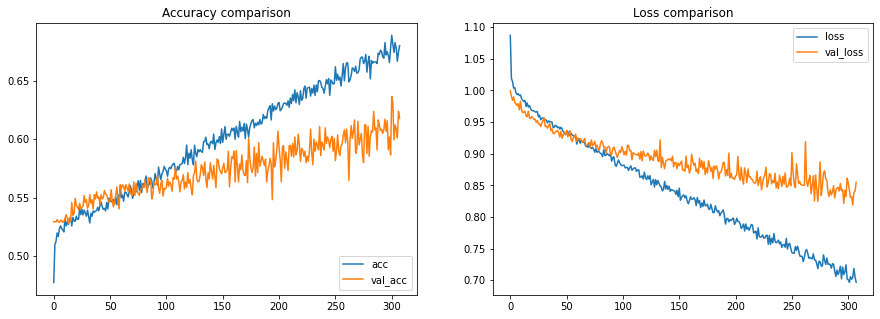

In [14]:
import matplotlib.pyplot as plt


plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(df['accuracy'], label='acc')
plt.plot(df['val_accuracy'], label='val_acc')
plt.legend(loc='lower right')
plt.title('Accuracy comparison')

plt.subplot(1, 2, 2)
plt.plot(df['loss'], label='loss')
plt.plot(df['val_loss'], label='val_loss')
plt.legend(loc='upper right')
plt.title('Loss comparison')

plt.show()

모델 평가

In [16]:
X_test = np.load('./X_test_128.npy',allow_pickle=True)/255
y_test = np.load('./y_test_128.npy',allow_pickle=True)
y_test = np.array(y_test).astype(np.float32)
trs.evaluate(X_test, y_test)

16/16 [==============================] - 3s 63ms/step - loss: 0.8961 - accuracy: 0.5996


[0.8961331248283386, 0.599609375]

In [17]:
import torch
y_test = torch.Tensor(y_test)
y_test = torch.argmax(y_test, dim=1)

In [18]:
y_pred_enc = trs.predict(X_test)          # one-hot encoding된 label 예측값
y_pred = [np.argmax(i) for i in y_pred_enc] # label 예측값
matrix = confusion_matrix(y_test, y_pred)
item = {
      0: 'Type 1'
    , 1: 'Type 2'
    , 2: 'Type 3'
}
res = pd.DataFrame(matrix)
res.columns = item.values()
res.index = item.values()
        
res

16/16 [==============================] - 1s 65ms/step


,Type 1,Type 2,Type 3
Type 1,19,58,10
Type 2,4,223,38
Type 3,0,95,65


### VGG19 전이학습 FineTuning Augumentation 사용안한 버전


In [19]:
'''# 사전 교육된 기본 모델 가져오기
base_model = VGG19(include_top=False, weights='imagenet',input_shape=(128, 128, 3))

base_model.trainable = False

# 교육할 계층 설정 최상위 계층만 교육하기 위해 (False 가중치 고정)
for layer in base_model.layers:
    layer.trainable = False
    
# 기본 모델의 마지막 층
x = base_model.output

x = Flatten()(x)
h1 = Dense(512, activation='relu')(x)
drop1 = Dropout(rate=0.5)(h1)
h2 = Dense(512, activation='relu')(drop1)
drop2 = Dropout(rate=0.5)(h2)
output = Dense(3, activation='softmax')(drop2)
'''
trs_non = Model(inputs=base_model.input, outputs=output)
trs_non.summary()
t_nongen = ImageDataGenerator().flow(X_valid, y_valid_onehot)
v_nongen = ImageDataGenerator().flow(X_train, y_train_onehot)

# t_gen.samples == size of train df

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 128, 128, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 128, 128, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 64, 64, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 64, 64, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 64, 64, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 32, 32, 128)       0   

세이빙한 모델 가져오는 부분

In [25]:
trs_non = keras.models.load_model('VGG19_nongenFT1.h5') #모델 가져오기
trs_non.compile(optimizer= SGD(lr=1e-4, momentum=0.9),
  loss='categorical_crossentropy', 
  metrics=['accuracy'])#옵티마이저 컴파일
general = trs_non.fit(t_nongen, validation_data= v_nongen, epochs= 60, verbose=1)
trs_non.save('VGG19_nongenFT2.h5')

Epoch 1/60
52/52 [==============================] - 16s 303ms/step - loss: 0.9255 - accuracy: 0.5447 - val_loss: 0.9525 - val_accuracy: 0.5328
Epoch 2/60
52/52 [==============================] - 15s 300ms/step - loss: 0.9196 - accuracy: 0.5782 - val_loss: 0.9517 - val_accuracy: 0.5359
Epoch 3/60
52/52 [==============================] - 16s 307ms/step - loss: 0.9197 - accuracy: 0.5569 - val_loss: 0.9503 - val_accuracy: 0.5409
Epoch 4/60
52/52 [==============================] - 16s 310ms/step - loss: 0.9235 - accuracy: 0.5563 - val_loss: 0.9498 - val_accuracy: 0.5383
Epoch 5/60
52/52 [==============================] - 16s 313ms/step - loss: 0.9220 - accuracy: 0.5636 - val_loss: 0.9485 - val_accuracy: 0.5381
Epoch 6/60
52/52 [==============================] - 16s 314ms/step - loss: 0.9146 - accuracy: 0.5758 - val_loss: 0.9506 - val_accuracy: 0.5366
Epoch 7/60
52/52 [==============================] - 16s 321ms/step - loss: 0.9247 - accuracy: 0.5533 - val_loss: 0.9543 - val_accuracy: 0.5407

KeyboardInterrupt: ignored

In [ ]:
#general = trs_non.fit(t_nongen, validation_data= v_nongen, epochs= 10, verbose=1)

In [21]:
with open('VGG19_nongenFT1.pkl', 'wb') as f:
	pickle.dump(general.history, f, protocol=pickle.HIGHEST_PROTOCOL)

In [23]:
# history 담은 pickle file
with open('VGG19_vernongen.pkl', 'rb') as f:
	df2 = pickle.load(f)

In [ ]:
# 옵티마이저 수정 전


plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(df2['accuracy'], label='acc')
plt.plot(df2['val_accuracy'], label='val_acc')
plt.legend(loc='lower right')
plt.title('Accuracy comparison')

plt.subplot(1, 2, 2)
plt.plot(df2['loss'], label='loss')
plt.plot(df2['val_loss'], label='val_loss')
plt.legend(loc='upper right')
plt.title('Loss comparison')

plt.show()

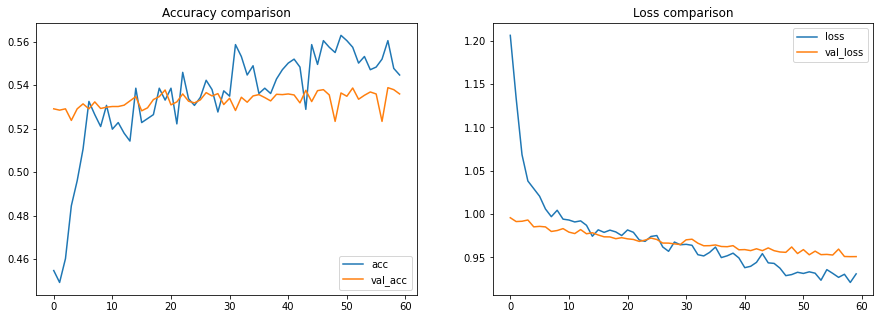

In [24]:
# 옵티마이저 수정 후


plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(df['accuracy'], label='acc')
plt.plot(df['val_accuracy'], label='val_acc')
plt.legend(loc='lower right')
plt.title('Accuracy comparison')

plt.subplot(1, 2, 2)
plt.plot(df['loss'], label='loss')
plt.plot(df['val_loss'], label='val_loss')
plt.legend(loc='upper right')
plt.title('Loss comparison')

plt.show()

모델 평가

In [ ]:
X_test = np.load('./X_test_128.npy',allow_pickle=True)/255
y_test = np.load('./y_test_128.npy',allow_pickle=True)
y_test = np.array(y_test).astype(np.float32)
trs_non.evaluate(X_test, y_test)

16/16 [==============================] - 96s 6s/step - loss: 1.4622 - accuracy: 0.6348


[1.4622313976287842, 0.634765625]

In [ ]:
import torch
y_test = torch.Tensor(y_test)
y_test = torch.argmax(y_test, dim=1)

In [ ]:
y_pred_enc = trs_non.predict(X_test)          # one-hot encoding된 label 예측값
y_pred = [np.argmax(i) for i in y_pred_enc] # label 예측값
matrix = confusion_matrix(y_test, y_pred)
item = {
      0: 'Type 1'
    , 1: 'Type 2'
    , 2: 'Type 3'
}
res = pd.DataFrame(matrix)
res.columns = item.values()
res.index = item.values()
        
res

16/16 [==============================] - 100s 6s/step


,Type 1,Type 2,Type 3
Type 1,32,40,15
Type 2,11,211,43
Type 3,2,76,82
